In [47]:
%load_ext autoreload
%autoreload 2
    
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.linear_model import Ridge
from lineartree import LinearTreeRegressor
from lib_FM import *
import random
import time
import pickle
from warnings import simplefilter

simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
random.seed(10)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### READING THE DATASET

In [48]:
df=pd.read_csv('./fairlymade_products_impacts.csv')
df.columns

Index(['study_id', 'product_type', 'nb_components', 'composition',
       'raw_material_country', 'weaving_country', 'dyeing_country',
       'manufacturing_country', 'plane_in_transports', 'climate_change',
       'resource_use_fossils'],
      dtype='object')

### ENCODING CATEGORICAL VARIABLES AND BUILDING TRAIN/VALIDATION DATASETS

In [49]:
categorical_features=['product_type','nb_components']
multi_valued_features=['composition','raw_material_country','weaving_country','dyeing_country','manufacturing_country']
boolean_features=['plane_in_transports']
numerical_features=['resource_use_fossils']

FED=FeaturesEncoderDecoder(categorical_features=categorical_features,
                           multi_valued_features=multi_valued_features,
                           boolean_features=boolean_features,
                           numerical_features=numerical_features)

In [50]:
target_feature="climate_change"
df=df.dropna(subset=[target_feature]+numerical_features)
y=np.array(df[target_feature])

In [51]:
df=df.drop_duplicates()
t1=time.time()
X=FED.encode_dataframe(df,compute_labels=True)
t2=time.time()
print("encoding dataset took %f"%(t2-t1))


encoding dataset took 0.699288


In [52]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25)


In [ ]:
best_score=None
alpha=1.
min_samples_leaf=3
min_impurity_decrease=0.00
for alpha in [0.01,1.,100.]:
    for min_samples_leaf in [0.0001,0.001,0.1]:
        for min_impurity_decrease in [0.0001,0.001,0.1]:
            reg=LinearTreeRegressor(base_estimator=Ridge(alpha=alpha),
                                    min_samples_leaf=min_samples_leaf,
                                    min_impurity_decrease=min_impurity_decrease,
                                    categorical_features=np.arange(FED.n_binary_features))
            scores=cross_val_score(reg,X_train,y_train)
            score=np.mean(scores)
            if best_score is None or best_score<score:
                best_score=score
                best_reg=reg
            print("alpha %f, min_samples_leaf %f, min_impurity_decrease %f : cv %s mean %f"%(alpha,min_samples_leaf,min_impurity_decrease,str(scores),score))
reg=best_reg

alpha 0.010000, min_samples_leaf 0.000100, min_impurity_decrease 0.000100 : cv [0.81775021 0.88679882 0.64508297 0.85494076 0.84930203] mean 0.810775
alpha 0.010000, min_samples_leaf 0.000100, min_impurity_decrease 0.001000 : cv [0.81775021 0.88679882 0.64508297 0.85494076 0.84930203] mean 0.810775
alpha 0.010000, min_samples_leaf 0.000100, min_impurity_decrease 0.100000 : cv [0.81775021 0.88679882 0.64508297 0.85494076 0.84930203] mean 0.810775
alpha 0.010000, min_samples_leaf 0.001000, min_impurity_decrease 0.000100 : cv [0.82101263 0.88873282 0.91309969 0.85513257 0.85245179] mean 0.866086
alpha 0.010000, min_samples_leaf 0.001000, min_impurity_decrease 0.001000 : cv [0.82101263 0.88873282 0.91309969 0.85513257 0.85245179] mean 0.866086
alpha 0.010000, min_samples_leaf 0.001000, min_impurity_decrease 0.100000 : cv [0.82101263 0.88873282 0.91309969 0.85513257 0.85245179] mean 0.866086
alpha 0.010000, min_samples_leaf 0.100000, min_impurity_decrease 0.000100 : cv [0.7369929  0.8370335

In [60]:
(alpha,min_samples_leaf,min_impurity_decrease,str(scores),score)

(0.01,
 0.0001,
 0.0001,
 '[0.81775021 0.88679882 0.64508297 0.85494076 0.84930203]',
 None)

In [54]:
reg.fit(X_train,y_train)
reg.score(X_val,y_val),reg.score(X_train,y_train)

(0.8660249387612083, 0.9098134723178717)

In [7]:
binary_features=np.array(["%s_%s"%(feature,label) for feature,feature_labels in FED.labels.items() for label in feature_labels]+FED.boolean_features)
binary_features=binary_features[np.argsort(reg.feature_importances_[:FED.n_binary_features])[::-1]]
binary_features

array(['composition_CASHMERE', 'composition_VIRGINWOOL',
       'composition_POLYESTER', 'composition_MERINOWOOL',
       'composition_COTTON', 'composition_SILK', 'composition_SHEEPWOOL',
       'nb_components_1', 'composition_VISCOSE', 'weaving_country_IT',
       'manufacturing_country_CN', 'product_type_PULLOVERS',
       'dyeing_country_IT', 'composition_ALPACAWOOL',
       'composition_POLYAMIDE', 'dyeing_country_CN', 'weaving_country_CN',
       'nb_components_2', 'manufacturing_country_IT',
       'manufacturing_country_TR', 'product_type_JACKETS & WORKVESTS',
       'composition_ACRYLIC', 'manufacturing_country_IN',
       'composition_ELASTANE', 'product_type_PANTS',
       'manufacturing_country_PT', 'composition_FLAX', 'nb_components_3',
       'dyeing_country_IN', 'product_type_BLAZERS & SUITS',
       'manufacturing_country_MA', 'composition_POLYPROPYLENE',
       'composition_POLYSTYRENE', 'composition_POLYURETHANE',
       'composition_POLYVINYLCHLORIDE', 'composition_R

### DATA VISUALIZATION NEW INSIGHTS

In [8]:
df=df.dropna(subset=["resource_use_fossils"])


global_corr : 0.425991, pos_corr : 0.732581, neg_corr : 0.861418,weighted_corr : 0.848069


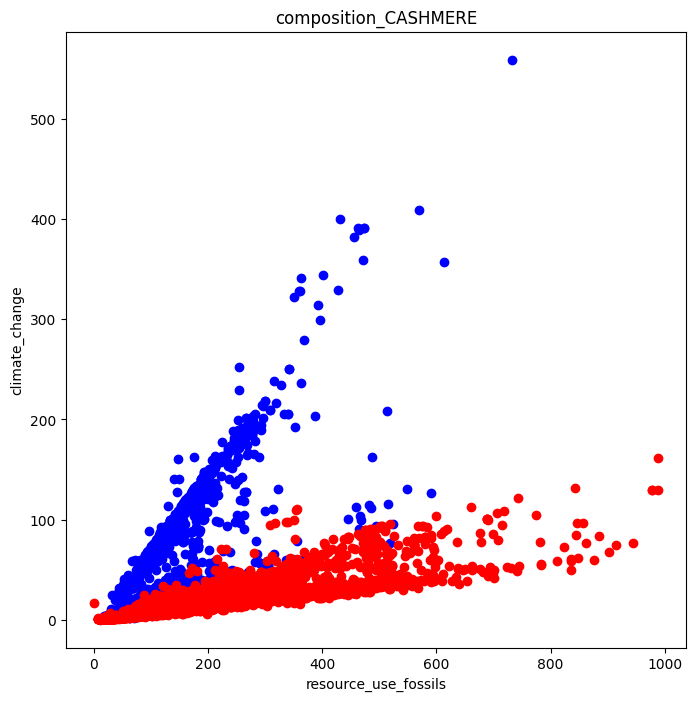

In [9]:
plt.rcParams['figure.figsize']=(8,8)

binary_feature=binary_features[0]
pos_df=df[df[binary_feature]]
neg_df=df[~df[binary_feature]]
x=df['resource_use_fossils']
y=df['climate_change']
x_pos=pos_df['resource_use_fossils']
y_pos=pos_df['climate_change']
x_neg=neg_df['resource_use_fossils']
y_neg=neg_df['climate_change']

global_corr=np.corrcoef(x, y)[0,1]
pos_corr=np.corrcoef(x_pos, y_pos)[0,1]
neg_corr=np.corrcoef(x_neg, y_neg)[0,1]
weighted_corr=len(x_pos)*pos_corr/len(x)+len(x_neg)*neg_corr/len(x)

print("global_corr : %f, pos_corr : %f, neg_corr : %f,weighted_corr : %f"%(global_corr,pos_corr,neg_corr,weighted_corr))

plt.scatter(x_pos,y_pos,c='b')
plt.scatter(x_neg,y_neg,c='r')
plt.xlabel('resource_use_fossils')
plt.ylabel('climate_change')
_=plt.title(binary_feature)

### EXTRACTING AND VISUALIZING LEAF CONFIGURATIONS

In [10]:
t1=time.time()
tree=reg.tree_
n_binary_features=tree.n_features
nx_tree=convert_tree(tree)
FED.compute_features(nx_tree)
leaf_configurations,leaf_values=extract_leaf_configuration(nx_tree)
decoded_configurations=[FED.decode_key_configuration(leaf_configuration) for leaf_configuration in leaf_configurations]
t2=time.time()
print("extracting configurations took %f"%(t2-t1))

extracting configurations took 0.041884


In [11]:
random.choice(decoded_configurations)

{'product_type': {'forbidden_labels': array([], dtype='<U19')},
 'nb_components': {'label': 1},
 'composition': {'forbidden_labels': array(['COTTON'], dtype='<U33'),
  'mandatory_labels': array(['CASHMERE'], dtype='<U33')},
 'raw_material_country': {'forbidden_labels': array([], dtype='<U2'),
  'mandatory_labels': array([], dtype='<U2')},
 'weaving_country': {'forbidden_labels': array([], dtype='<U2'),
  'mandatory_labels': array([], dtype='<U2')},
 'dyeing_country': {'forbidden_labels': array([], dtype='<U2'),
  'mandatory_labels': array([], dtype='<U2')},
 'manufacturing_country': {'forbidden_labels': array([], dtype='<U2'),
  'mandatory_labels': array([], dtype='<U2')},
 'plane_in_transports': None,
 'resource_use_fossils': {'min': 75.75160217285156, 'max': 80.77710342407227}}

### SAVING DATA

In [13]:
model_path="./model.p"
features_encoder_decoder_path="./features_encoder_decoder.p"
leaf_configurations_path="./leaf_configurations.p"
leaf_values_path="./leaf_values.npy"

with open(model_path,"wb") as file:
    pickle.dump(reg,file)
with open(features_encoder_decoder_path,"wb") as file:
    pickle.dump(FED,file)
with open(leaf_configurations_path,"wb") as file:
    pickle.dump(leaf_configurations,file)
np.save(leaf_values_path,leaf_values)